In [137]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from yahist import Hist1D, Hist2D

from utils import set_plotting_style, get_chunking, get_chunking_dask

In [138]:
set_plotting_style()

In [5]:
def get_eff(t):
    den = t["pass_fiducialgen_norho"].array() # doesn't require gen rho < 11cm
#     den = t["pass_fiducialgen"].array()
    num = t["pass_l1"].array() & t["pass_skim"].array()
    eff = (num & den).sum() / den.sum()
    return eff, den.sum()
effs = []
fnames = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd*_ctau*mm_BABY_v5/output_1.root")
for fname in tqdm(fnames):
    mzd = int(fname.split("_mzd")[1].split("_")[0])
    ctau = int(fname.split("_ctau")[1].split("mm")[0])
    t = uproot.open(fname)["Events"]
    eff, den = get_eff(t)
    effs.append(dict(mzd=mzd,ctau=ctau,eff=eff,den=den,nevents=len(t)))
df = pd.DataFrame(effs)

In [6]:
df.pivot_table(columns=["ctau"],values=["nevents","den"],index="mzd")

den               nevents                
ctau     10     25     50      10      25      50
mzd                                              
5     63944  63962  63962   99500   99500   99500
8     64029  64029  64029  100000  100000  100000
10    63164  63197  63186   99500   99500   99500
12    63207  63521  63521   99500  100000  100000
15    63615  63615  63615  100000  100000  100000
18    64200  64200  62910  100000  100000   98000
20    64334  63987  63675   99500   99000   98500
25    66884  66235  66245  100000   99000   99000

In [7]:
(df["den"]/df["nevents"]).mean()

0.6433590127468721

Text(0.5, 1.0, 'efficiency')

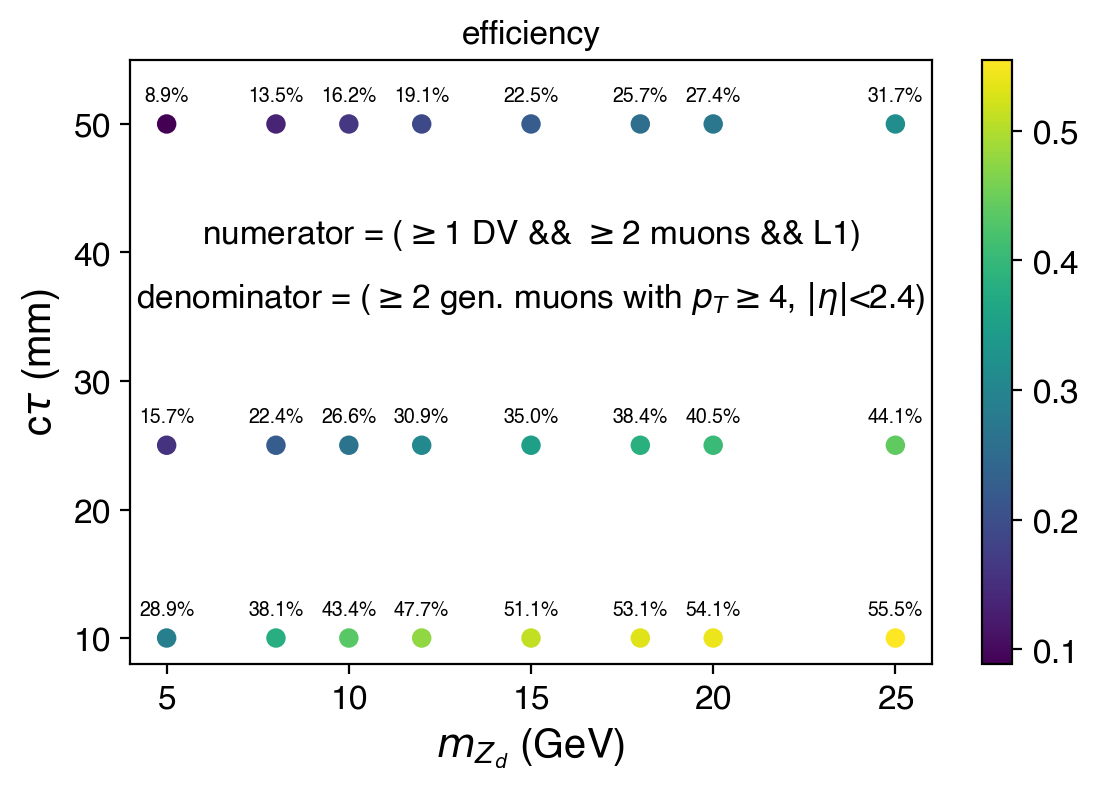

In [8]:
fig, ax = plt.subplots()
xs = df["mzd"]
ys = df["ctau"]
zs = df["eff"]
# zs = df["nevents"]
plt.scatter(x=xs,y=ys,c=zs,cmap="viridis")
plt.colorbar()
for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
    s = "{:.1f}%".format(100*z)
#     s = "{:.1f}k".format(z/1000.)
    ax.text(x,y+1.5,s,fontsize=7,horizontalalignment="center",verticalalignment="bottom")
ax.set_xlim([4,26])
ax.set_ylim([8,55])
ax.set_xlabel(r"$m_{Z_d}$ (GeV)")
ax.set_ylabel(r"c$\tau$ (mm)")
ax.set_title("efficiency. numer.=(nDV>=1 && nMu>=2 && L1), denom.=(>=2 mu with pT>4, |eta|<2.4)")

ax.text(15,40,r"numerator = ($\geq$1 DV && $\geq$2 muons && L1)",fontsize=12,horizontalalignment="center",verticalalignment="bottom")
ax.text(15,35,r"denominator = ($\geq$2 gen. muons with $p_T\geq$4, $|\eta|$<2.4)",fontsize=12,horizontalalignment="center",verticalalignment="bottom")
ax.set_title("efficiency")

In [144]:
def get_eff(fname):
    denomsel = " and ".join([
        "pass_baseline_iso",
        "DV_rhoCorr>1.0",
    ])
    numsel = " and ".join([
        "logabsetaphi<2",
#         "minabsdxy>0.05",
    ]) + " and " + denomsel
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(
        ["pass_*","logabs*","minabs*","DV_rhoCorr", "dimuon_mass","dimuon_pt"],
        namedecode="ascii",
        outputtype=dict)
    df = pd.DataFrame()
    for k in arrs.keys():
        if k.startswith("DV_"):
            df[k] = arrs[k][:,0]
        elif k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][:,1]
        else:
            df[k] = arrs[k]
#     df["dxythresh"] = df.eval("1.0 * DV_rhoCorr * dimuon_mass * dimuon_pt")
    den = df.eval(denomsel).sum()
    num = df.eval(numsel).sum()
    return (num, den, num/den)

fnames = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd*_ctau*mm_BABY_v10/output_1.root")

effs = []
for fname in tqdm(fnames):
    mzd = int(fname.split("_mzd")[1].split("_")[0])
    ctau = int(fname.split("_ctau")[1].split("mm")[0])
    t = uproot.open(fname)["Events"]
    num, den, eff = get_eff(fname)
    effs.append(dict(mzd=mzd,ctau=ctau,eff=eff,den=den,num=num))
    
df = pd.DataFrame(effs)
df.head()

,mzd,ctau,eff,den,num
0,10,10,0.990929,8158,8084
1,10,1,0.990036,2509,2484
2,10,25,0.993686,5543,5508
3,10,50,0.991192,3406,3376
4,10,5,0.990061,8049,7969


[1, 5, 10, 25, 50]
uaf-10.t2.ucsd.edu/~namin/dump/sigeff_logabsetaphi_baselinerho1cm.pdf


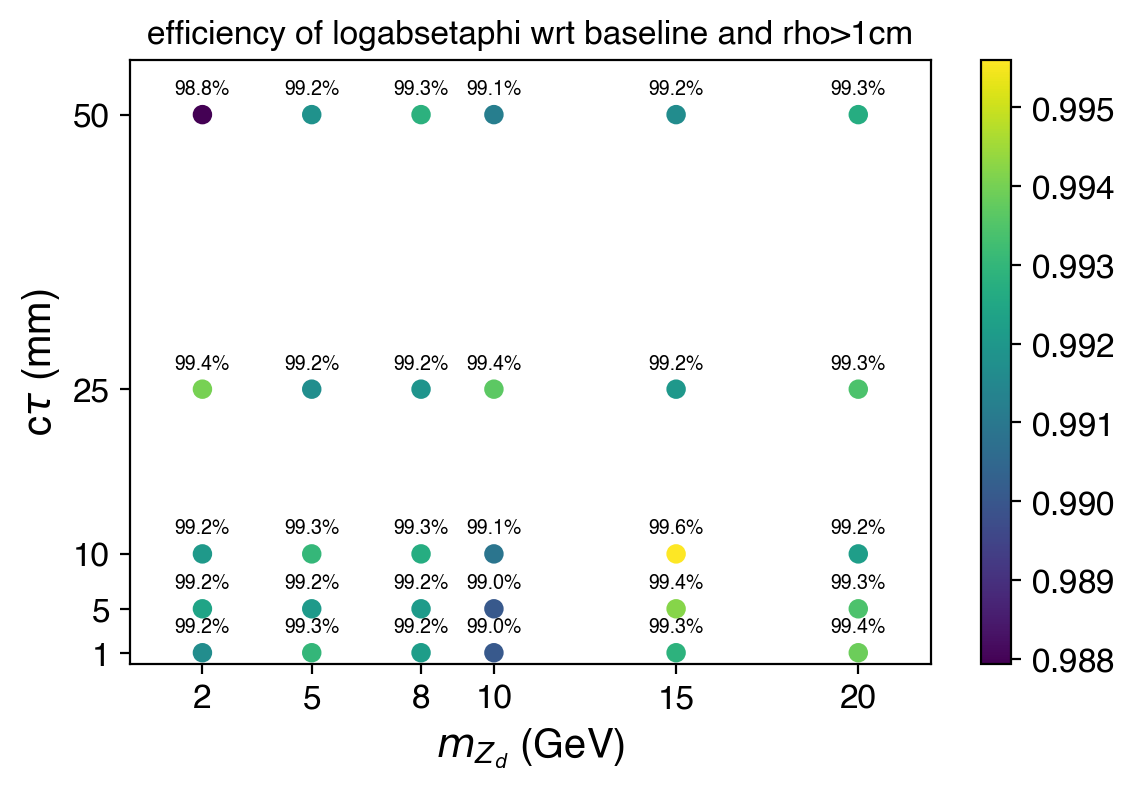

In [146]:
fig, ax = plt.subplots()
xs = df["mzd"]
ys = df["ctau"]
zs = df["eff"]
nums = df["num"]
# zs = df["num"]
plt.scatter(x=xs,y=ys,c=zs,cmap="viridis")
plt.colorbar()
for i,(x,y,z,n) in enumerate(zip(xs,ys,zs,nums)):
    s = "{:.1f}%".format(100*z)
#     s = "{:.1f}k".format(z/1000.)
    ax.text(x,y+1.5,s,fontsize=7,horizontalalignment="center",verticalalignment="bottom")
ax.set_xlim([0,22])
ax.set_ylim([0,55])
ax.set_xlabel(r"$m_{Z_d}$ (GeV)")
ax.set_ylabel(r"c$\tau$ (mm)")
ax.set_title("efficiency")

masses = sorted(xs.unique())
ctaus = sorted(ys.unique())
print(ctaus)
plt.xticks(masses,["{:g}".format(x) for x in masses])
plt.yticks(ctaus,["{:g}".format(x) for x in ctaus])

ax.set_title("efficiency of logabsetaphi wrt baseline and rho>1cm")

# ax.tricontour(xs,ys,zs, 10, linewidths=1.0)

fig.savefig("sigeff_logabsetaphi_baselinerho1cm.pdf")
!web sigeff_logabsetaphi_baselinerho1cm.pdf

In [66]:
def get_df(fname):
#     denomsel = " and ".join([
#         "pass_baseline_iso",
#         "DV_rhoCorr>1.0",
#     ])
#     numsel = " and ".join([
# #         "logabsetaphi<2",
#         "minabsdxy>0.05",
#     ]) + " and " + denomsel
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(
        ["pass_*","logabs*","minabs*","DV_rhoCorr", "dimuon_mass","dimuon_pt"],
        namedecode="ascii",
        outputtype=dict)
    df = pd.DataFrame()
    for k in arrs.keys():
        if k.startswith("DV_"):
            df[k] = arrs[k][:,0]
        elif k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][:,1]
        else:
            df[k] = arrs[k]
    df["dxythresh"] = df.eval("0.1 * DV_rhoCorr * dimuon_mass / dimuon_pt")
    df["dxyratio"] = df.eval("minabsdxy / dxythresh")
    
    df = df.query("logabsetaphi<2.0 and DV_rhoCorr>1.0 and pass_baseline_iso")
    return df
#     den = df.eval(denomsel).sum()
#     num = df.eval(numsel).sum()
#     return (num, den, num/den)

fnames = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd*_ctau*mm_BABY_v10/output_1.root")

dfs = []
for fname in tqdm(fnames):
    mzd = int(fname.split("_mzd")[1].split("_")[0])
    ctau = int(fname.split("_ctau")[1].split("mm")[0])
    t = uproot.open(fname)["Events"]
    df = get_df(fname)
    df["mzd"] = mzd
    df["ctau"] = ctau
    dfs.append(df)
dfc = pd.concat(dfs).reset_index(drop=True)
dfc.head()

,pass_skim,pass_l1,pass_fiducialgen,pass_fiducialgen_norho,pass_baseline,pass_baseline_iso,logabsetaphi,minabsdxy,DV_rhoCorr,dimuon_mass,dimuon_pt,dxythresh,dxyratio,mzd,ctau
0,True,True,True,True,True,True,0.868020,0.063768,5.422139,9.959579,57.337902,0.094182,0.677069,10,10
1,True,True,True,True,True,True,0.011721,0.506320,10.062832,6.744040,50.797840,0.133597,3.789919,10,10
2,True,True,True,True,True,True,0.884658,0.030833,1.408596,9.929518,35.600582,0.039288,0.784789,10,10
3,True,True,True,True,True,True,0.702847,0.101589,7.766081,10.001136,83.408905,0.093119,1.090953,10,10
4,True,True,True,True,True,True,0.913341,0.089570,5.638653,9.863317,48.801071,0.113964,0.785951,10,10


Text(0.5, 1.0, 'minabsdxy/(0.1*rho*mass/dimupt) [baseline, rho>1cm]')

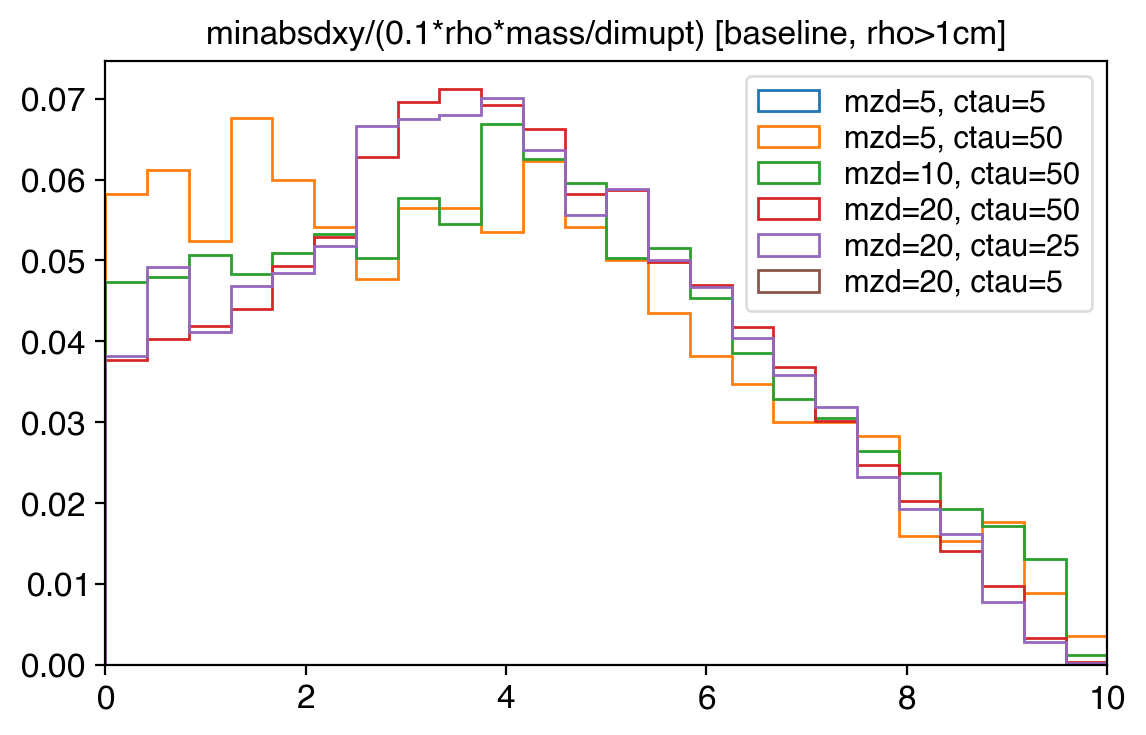

In [70]:
# var = "dxythresh"
# bins = np.linspace(0,1,100)
var = "dxyratio"
bins = np.linspace(0,10,25)
Hist1D(dfc.query("mzd==5 and ctau==5")[var],bins=bins).normalize().plot(label="mzd=5, ctau=5",histtype="step")
Hist1D(dfc.query("mzd==5 and ctau==50")[var],bins=bins).normalize().plot(label="mzd=5, ctau=50",histtype="step")
Hist1D(dfc.query("mzd==10 and ctau==50")[var],bins=bins).normalize().plot(label="mzd=10, ctau=50",histtype="step")
Hist1D(dfc.query("mzd==20 and ctau==50")[var],bins=bins).normalize().plot(label="mzd=20, ctau=50",histtype="step")
Hist1D(dfc.query("mzd==20 and ctau==25")[var],bins=bins).normalize().plot(label="mzd=20, ctau=25",histtype="step")
Hist1D(dfc.query("mzd==20 and ctau==5")[var],bins=bins).normalize().plot(label="mzd=20, ctau=5",histtype="step")
ax = plt.gca()

ax.legend()
ax.set_title("minabsdxy/(0.1*rho*mass/dimupt) [baseline, rho>1cm]")

In [82]:
dfc["pass_ratio"] = dfc.eval("dxyratio>1.0")

dfc.groupby(["mzd","ctau"])["pass_ratio"].mean().unstack(["ctau"])

ctau,10,25,50
mzd,,,
2,0.881617,0.882971,0.881954
5,0.864321,0.864865,0.857647
8,0.869711,0.883451,0.874277
10,0.877412,0.879448,0.884182
15,0.885617,0.893767,0.893572
20,0.897598,0.897491,0.904969
